<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/5_Dinamic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

# Feature engineering and scaling

In [4]:
data = mf.feature_engineering(data)
data = mf.feature_scaling(data)
data = pd.get_dummies(data)

# Dynamic model

In [5]:
initial_splits = 4
splits = 2
tot_splits = 10   

def split_data(data, tot_splits, verbose = False):
  n_data = {}
  dati_splitted = []
  dati_fraud = []

  for i in range(tot_splits):
    dati_splitted.append(data[(data['TransactionDT']>=(i/tot_splits)) & (data['TransactionDT']<((i + 1)/tot_splits))]) 
    dati_fraud.append(dati_splitted[i][dati_splitted[i]['isFraud'] == 1])
    if verbose: 
      dati_per_split = dati_splitted[i].count()[0]  
      fraud_per_split = dati_fraud[i].count()[0]  
      density = fraud_per_split / dati_per_split
      n_data[i] = [dati_per_split, fraud_per_split, density.round(3)]
  if verbose:
    print(n_data)
    print(dati_splitted)
    print(dati_fraud)

  return dati_splitted, dati_fraud

dati_splitted, dati_fraud = split_data(data, tot_splits, verbose = False)

In [6]:
class ensemble:
  def __init__(self):
    self.score = 0
    self.precision = 0
    self.recall = 0
    self.pred = []
    self.proba = []
    self.roc = 0
    return 

  def predictions(self, X_val, xgb, soglia = 0.05):
    from sklearn.metrics import roc_auc_score
    y_mean = []
    y_pred = []
    self.proba = []

    for t in xgb:
      ''' if model_t is ensemble: predict
          else: predict_proba '''
      self.proba.append(xgb[t].predict_proba(X_val, validate_features = False)[:, 1]) 

    y_mean = np.mean(self.proba, axis = 0)
    for p in y_mean:
      if p > soglia:
        y_pred.append(1)
      else:
        y_pred.append(0)
    return y_pred


  def performance(self, y_val):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import f1_score, recall_score, precision_score

    mf.plot_cm(y_val, self.pred, 'Blues', p = 0.05, dynamic = True)
    print('\n')
    print('Ensemble confusion matrix')

    self.score = f1_score(y_val, self.pred).round(2)
    self.roc = roc_auc_score(y_val, self.pred).round(2)
    self.precision = precision_score(y_val, self.pred,  average='binary').round(2)
    self.recall = recall_score(y_val, self.pred, average='binary').round(2)

    print('\n')
    print('Ensemble f1 score: ', self.score)
    print('Ensemble model roc auc score: ', self.roc)
    print('Ensemble model recall: ', self.recall)
    print('Ensemble model precision: ', self.precision)
    print('\n')

    return


  def voting(self, X_val, y_val, xgb):
    self.pred = ensemble.predictions(self, X_val, xgb)
    ensemble.performance(self, y_val)
    return self.pred , self.score


In [7]:
def predictions(model, X_val, soglia = 0.05):
  y_pred = []
  proba = model.predict_proba(X_val, validate_features = False)
  for p in proba[:, 1]:
    if p > soglia:
      y_pred.append(1)
    else:
      y_pred.append(0)
  return y_pred, proba

In [8]:
def fraud_extraction(data, X_train, y_train, t):
  if t > 0:
    y = data['isFraud']
    X = data.drop(['isFraud'], axis = 1)
    X_train = pd.concat([X_train, X], axis=0)
    y_train = pd.concat([y_train, y], axis=0)
  return X_train, y_train

In [9]:
def train_and_test_model(data, data_fraud, model_t, xgb, ens, score_t, t, keep_fraud = False):
  import xgboost 
  from xgboost import XGBClassifier
  from sklearn.metrics import roc_auc_score
  from sklearn.metrics import f1_score

  print('Training new model')
  X_train, X_val, y_train, y_val = mf.split(data, test_size = 0.2)
  if keep_fraud:
    X_train, y_train = fraud_extraction(data_fraud, X_train, y_train, t)

  xgb[t] = XGBClassifier(n_estimators = 1000, max_depth = 6, 
                      objective='binary:logistic', learning_rate = 0.5, 
                      tree_method='gpu_hist')
  xgb[t].fit(X_train.to_numpy(), y_train.to_numpy())

  print('New xgb performance')
  soglie = [0.05]  
  y_pred, proba = predictions(xgb[t], X_val)
  mf.tresh(soglie, proba, y_val.to_numpy(), 'Blues')
  '''
  il modello viene testato solo sui nuovi dati
  potrebbe essere meglio testarlo su tutti i dati precedenti.
  se si fa cos', implemetarlo anche per l'ensemble
  '''
  new_score = f1_score(y_val, y_pred) # test del nuovo xgb sui nuovi dati 

  if t > 0:
    old_score = score_t[t-1]
    ens.voting(X_val, y_val, xgb)

    score_dict = {
        'new': new_score,
        'old': old_score,
        'ensemble': ens.score
    }

    print('Scores \n', score_dict)
    print('Selecting best model')
    import operator
    best_model = max(score_dict.items(), key=operator.itemgetter(1))[0]
    best_score = score_dict[best_model]

    if best_model == 'new':
      return xgb[t], best_score, xgb[t]
    if best_model == 'old':
      return model_t[t-1], best_score, xgb[t-1]
    if best_model == 'ensemble':
      return ens, ens.score, xgb[t]
  else:
    return xgb[t], new_score, xgb[t]

Current iteration:  0
Training new model
New xgb performance
Soglia:  0.05
F1 score:  0.79
Recall:  0.8
Precision:  0.79




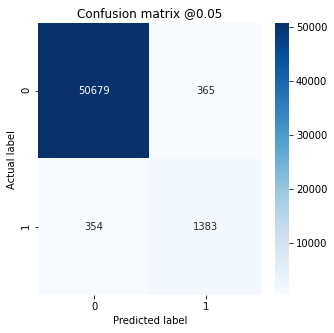



Best current model f1 score:  0.79
Current iteration:  1
Training new model
New xgb performance
Soglia:  0.05
F1 score:  0.8
Recall:  0.78
Precision:  0.81




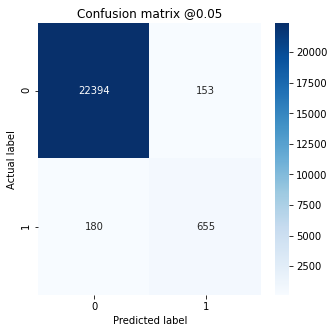

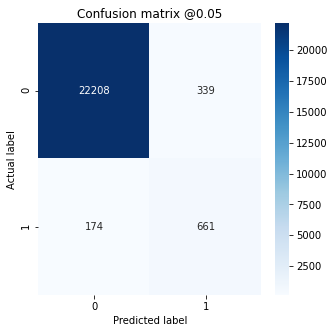

Ensemble confusion matrix
Ensemble f1 score:  0.72
Ensemble model recall:  0.89
Ensemble model recall:  0.79
Ensemble model precision:  0.66
Scores 
 {'new': 0.7973219720024346, 'old': 0.7936872309899569, 'ensemble': 0.72}
Selecting best model
Best current model f1 score:  0.8
Current iteration:  2
Training new model
New xgb performance
Soglia:  0.05
F1 score:  0.79
Recall:  0.81
Precision:  0.78




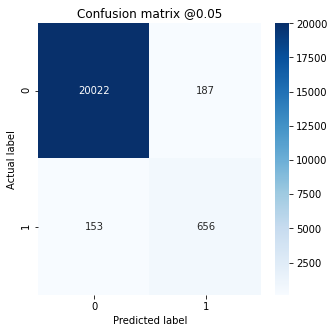

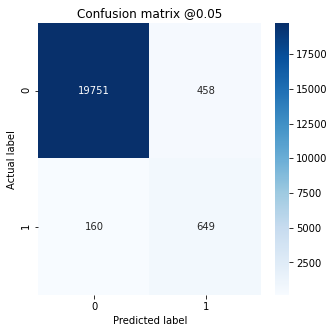

Ensemble confusion matrix
Ensemble f1 score:  0.68
Ensemble model recall:  0.89
Ensemble model recall:  0.8
Ensemble model precision:  0.59
Scores 
 {'new': 0.794188861985472, 'old': 0.7973219720024346, 'ensemble': 0.68}
Selecting best model
Best current model f1 score:  0.8
Current iteration:  3
Training new model
New xgb performance
Soglia:  0.05
F1 score:  0.8
Recall:  0.78
Precision:  0.82




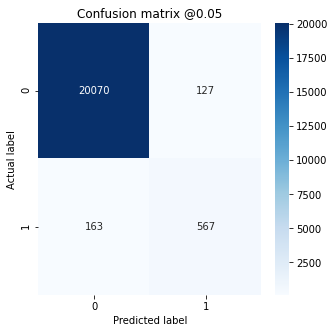

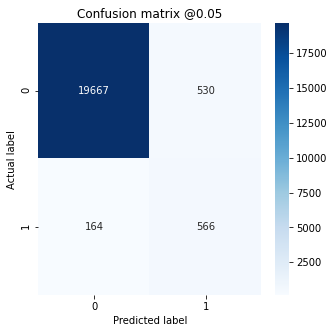

Ensemble confusion matrix
Ensemble f1 score:  0.62
Ensemble model recall:  0.87
Ensemble model recall:  0.78
Ensemble model precision:  0.52
Scores 
 {'new': 0.7963483146067416, 'old': 0.7973219720024346, 'ensemble': 0.62}
Selecting best model
Best current model f1 score:  0.8
Score:  0.7973219720024346
Model:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)


In [10]:
def dinamic_model(initial_splits, splits, tot_splits, data, data_fraud):
  tmax = np.ceil((tot_splits) / splits) #  massimo numero di iterazioni possibili 
  data_t = {} # contiene i dati dello split 
  data_fraud_t = {} # contiene le transazioni fraudolente 
  model_t = {} # contiene il modello in uso al tempo t
  xgb = {} # contiene gli xgb trainati solo sullo split t 
  score_t = {} # contiene lo score dei modelli 
  ens = ensemble() # ensemble dei modelli 

  for t in range(int(tmax - 1)):
    if t == 0:
      start = 0
      end = initial_splits
      data_fraud_t[t] = None
    else:
      start = splits * (t - 1) + initial_splits
      end = start + splits
      start_fraud = splits * (t - 2) + initial_splits
      end_fraud = start + splits
      data_fraud_t[t] = pd.concat(data_fraud[start_fraud:end_fraud])
    data_t[t] = pd.concat(dati_splitted[start:end])
    print('\n')
    print('\n')
    print('Current iteration: ', t)
    model_t[t], score_t[t], xgb[t] = train_and_test_model(data_t[t], data_fraud_t[t], model_t, xgb, ens, score_t, t, keep_fraud = False) # ricavo il modello più performante
    print('Best current model f1 score: ', score_t[t].round(2)) 
    print('\n')
  return model_t[t], score_t[t], xgb[t]

model, score, xgb = dinamic_model(initial_splits, splits, tot_splits, data, dati_fraud)
print('Score: ', score)
print('Model: ', model)

In [11]:
# X_train, X_val, y_train, y_val = mf.split(pd.concat(dati_splitted[:initial_splits - 1]), test_size = 0.2)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)